In [1]:
import IPython
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydot

import kaggle
import os
import glob
import shutil
import time
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())
tf.get_logger().setLevel('INFO')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

%load_ext tensorboard
!rm -rf ./cDCGAN/logs/
    
BASE_DIR = "/home/simon/Documents/W-Seminar/"

2022-11-03 18:28:49.704281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 18:28:49.804263: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 18:28:50.221168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/simon/anaconda3/envs/tf/lib/
2022-11-03 18:28:50.221214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

Num GPUs Available:  1
/device:GPU:0
/usr/bin/zsh: /home/simon/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


2022-11-03 18:28:51.723862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 18:28:51.727518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 18:28:51.727624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 18:28:51.727964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 256

generator_optimizer = keras.optimizers.Adam(2e-4)
discriminator_optimizer = keras.optimizers.Adam(2e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
dataset = tf.keras.utils.image_dataset_from_directory(
  os.path.join(BASE_DIR, "dataset/preprocessed"),
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)
class_names = dataset.class_names
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

Found 214692 files belonging to 2 classes.


2022-11-03 18:28:56.472176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 18:28:56.472307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 18:28:56.472383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 18:28:56.472479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 18:28:56.472558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

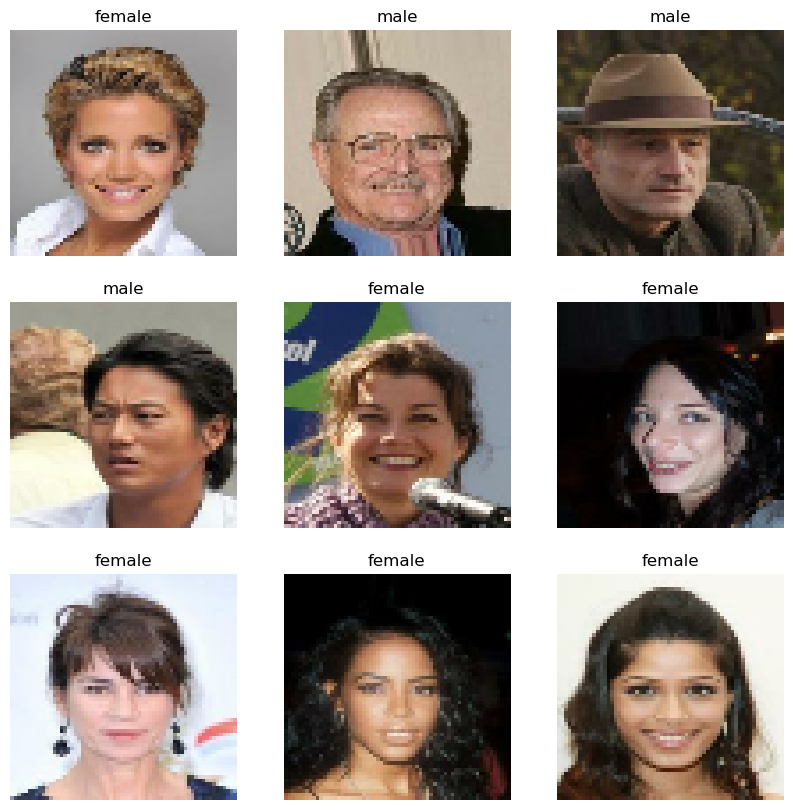

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1).cache():
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy()*127.5+127.5).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
def make_generator_model():
    gen_input = layers.Input((100,), name="latent_vector")
    
    gen = layers.Dense(8*8*100, use_bias=False)(gen_input)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Reshape((8, 8, 100))(gen)
    
    label_input = layers.Input((1,), name="label")
    label = layers.Embedding(2, 50)(label_input)
    label = layers.Dense(8*8)(label)
    label = layers.Reshape((8,8,1))(label)
    
    gen = layers.Concatenate()([gen, label])
    
    gen = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Dropout(0.5)(gen)

    gen = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    
    gen = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Dropout(0.5)(gen)
    
    gen = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    
    out_layer = layers.Conv2D(3, (5, 5), padding="same", use_bias=False,  activation='tanh')(gen)
    
    model = keras.Model([gen_input, label_input], out_layer)
    assert out_layer.shape == (None, 64, 64,3)
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_vector (InputLayer)     [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 6400)         640000      ['latent_vector[0][0]']          
                                                                                                  
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 6400)        25600       ['dense[0][0]']                  
 alization)                                                                                   

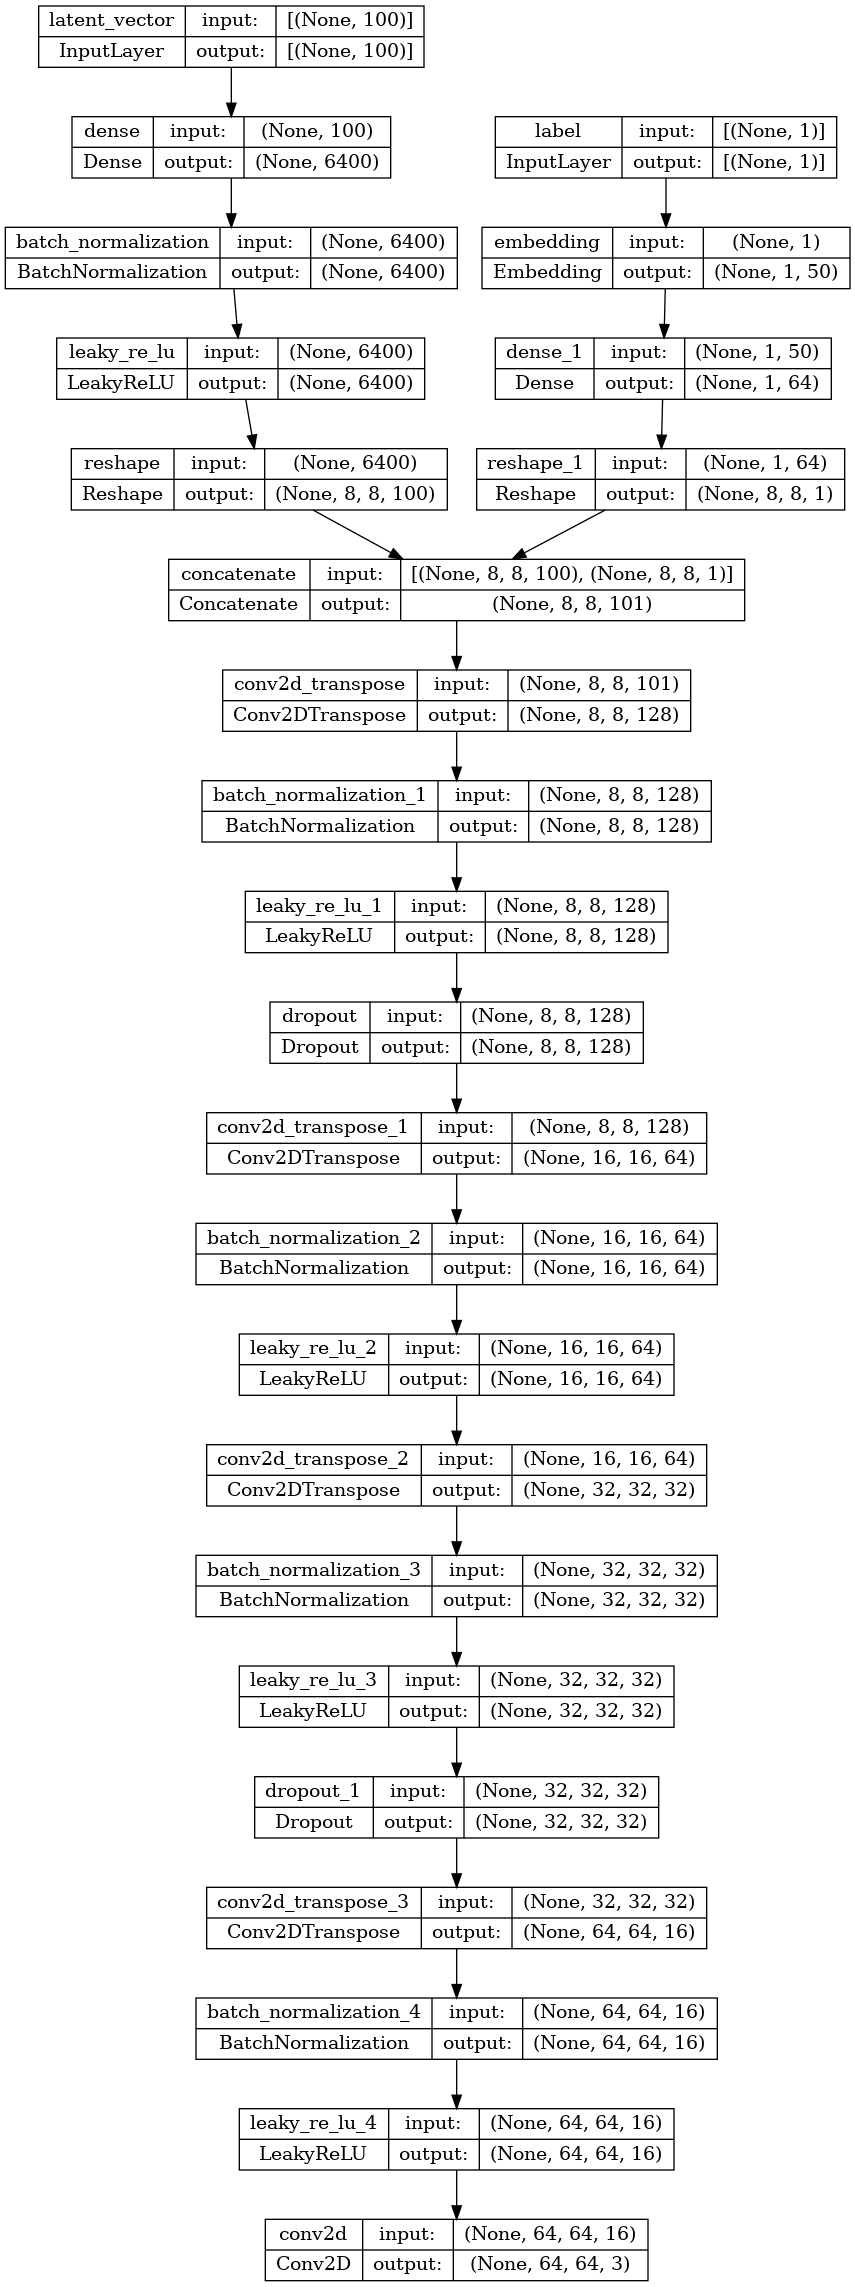

In [6]:
generator = make_generator_model()
generator.summary()
tf.keras.utils.plot_model(generator, "cDCGAN/cDCGenerator.png", show_shapes=True)

In [7]:
def make_discriminator_model(optimizer):
    label_input = layers.Input((1,), name="label")
    label = layers.Embedding(2, 50)(label_input)
    label = layers.Dense(64*64)(label)
    label = layers.Reshape((64,64,1))(label)
    
    image_input = layers.Input((64, 64, 3), name="image")
    
    disc = layers.Concatenate()([image_input, label])
    disc = layers.Conv2D(64, (5, 5), strides=(2,2), padding='same')(disc)
    disc = layers.LeakyReLU(alpha=0.2)(disc)
    disc = layers.Dropout(0.3)(disc)
    
    disc = layers.Conv2D(128, (5, 5), strides=(2,2), padding='same')(disc)
    disc = layers.LeakyReLU(alpha=0.2)(disc)
    disc = layers.Dropout(0.3)(disc)
    
    disc = layers.Flatten()(disc)
    disc = layers.Dropout(0.3)(disc)
    output_layer = layers.Dense(1, activation='leaky_relu')(disc)
    
    model = keras.Model([image_input, label_input], output_layer)
    model.compile(optimizer, loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=["acc"])
    return model
    

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_vector (InputLayer)     [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 6400)         640000      ['latent_vector[0][0]']          
                                                                                                  
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 6400)        25600       ['dense[0][0]']                  
 alization)                                                                                   

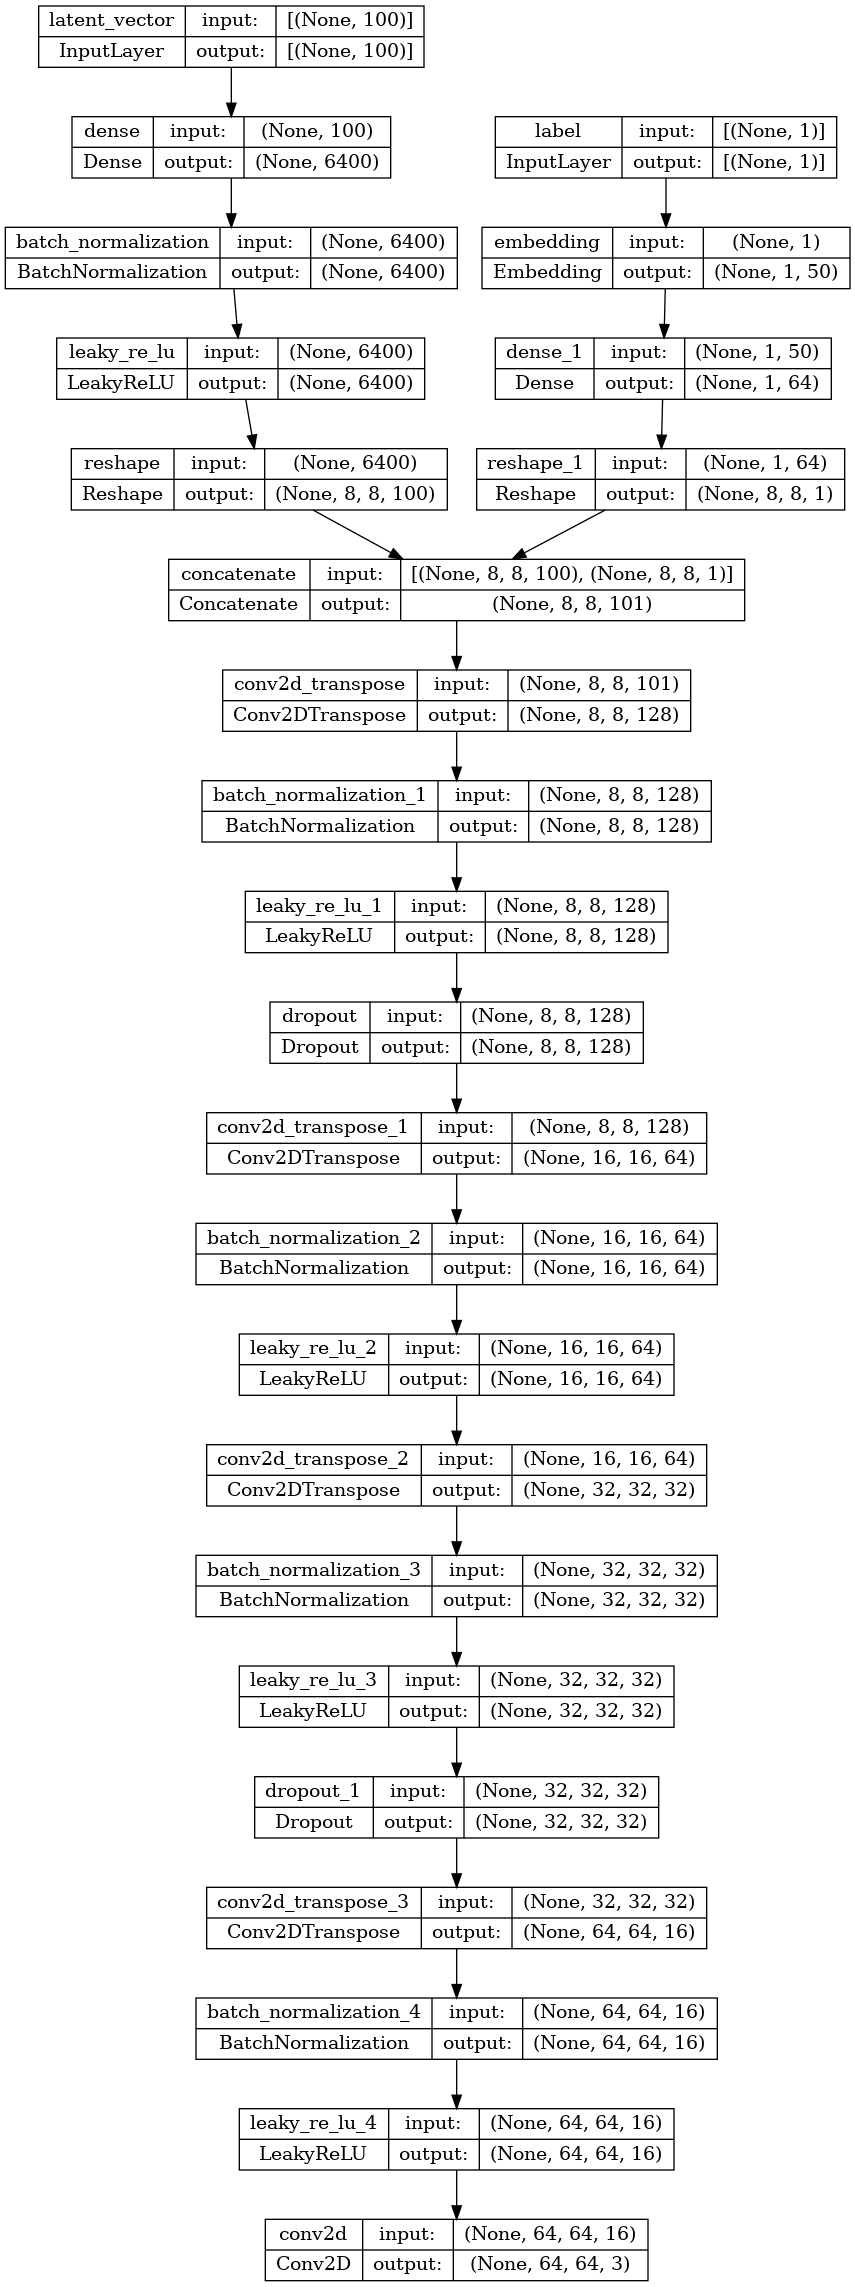

In [8]:
discriminator = make_discriminator_model(discriminator_optimizer)
generator.summary()
tf.keras.utils.plot_model(generator, "cDCGAN/cDCDiscriminator.png", show_shapes=True)

In [9]:
def make_gan_model(discrimiator: keras.Model, generator: keras.Model):
    discrimiator.trainable = False
    gen_noise_input, gen_label_input = generator.input
    gen_output = generator.output
    
    gan_output = discrimiator([gen_output, gen_label_input])
    model = keras.Model([gen_noise_input, gen_label_input], gan_output)
    model.compile(generator_optimizer, loss=cross_entropy)
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_vector (InputLayer)     [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 6400)         640000      ['latent_vector[0][0]']          
                                                                                                  
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 6400)        25600       ['dense[0][0]']                  
 alization)                                                                                 

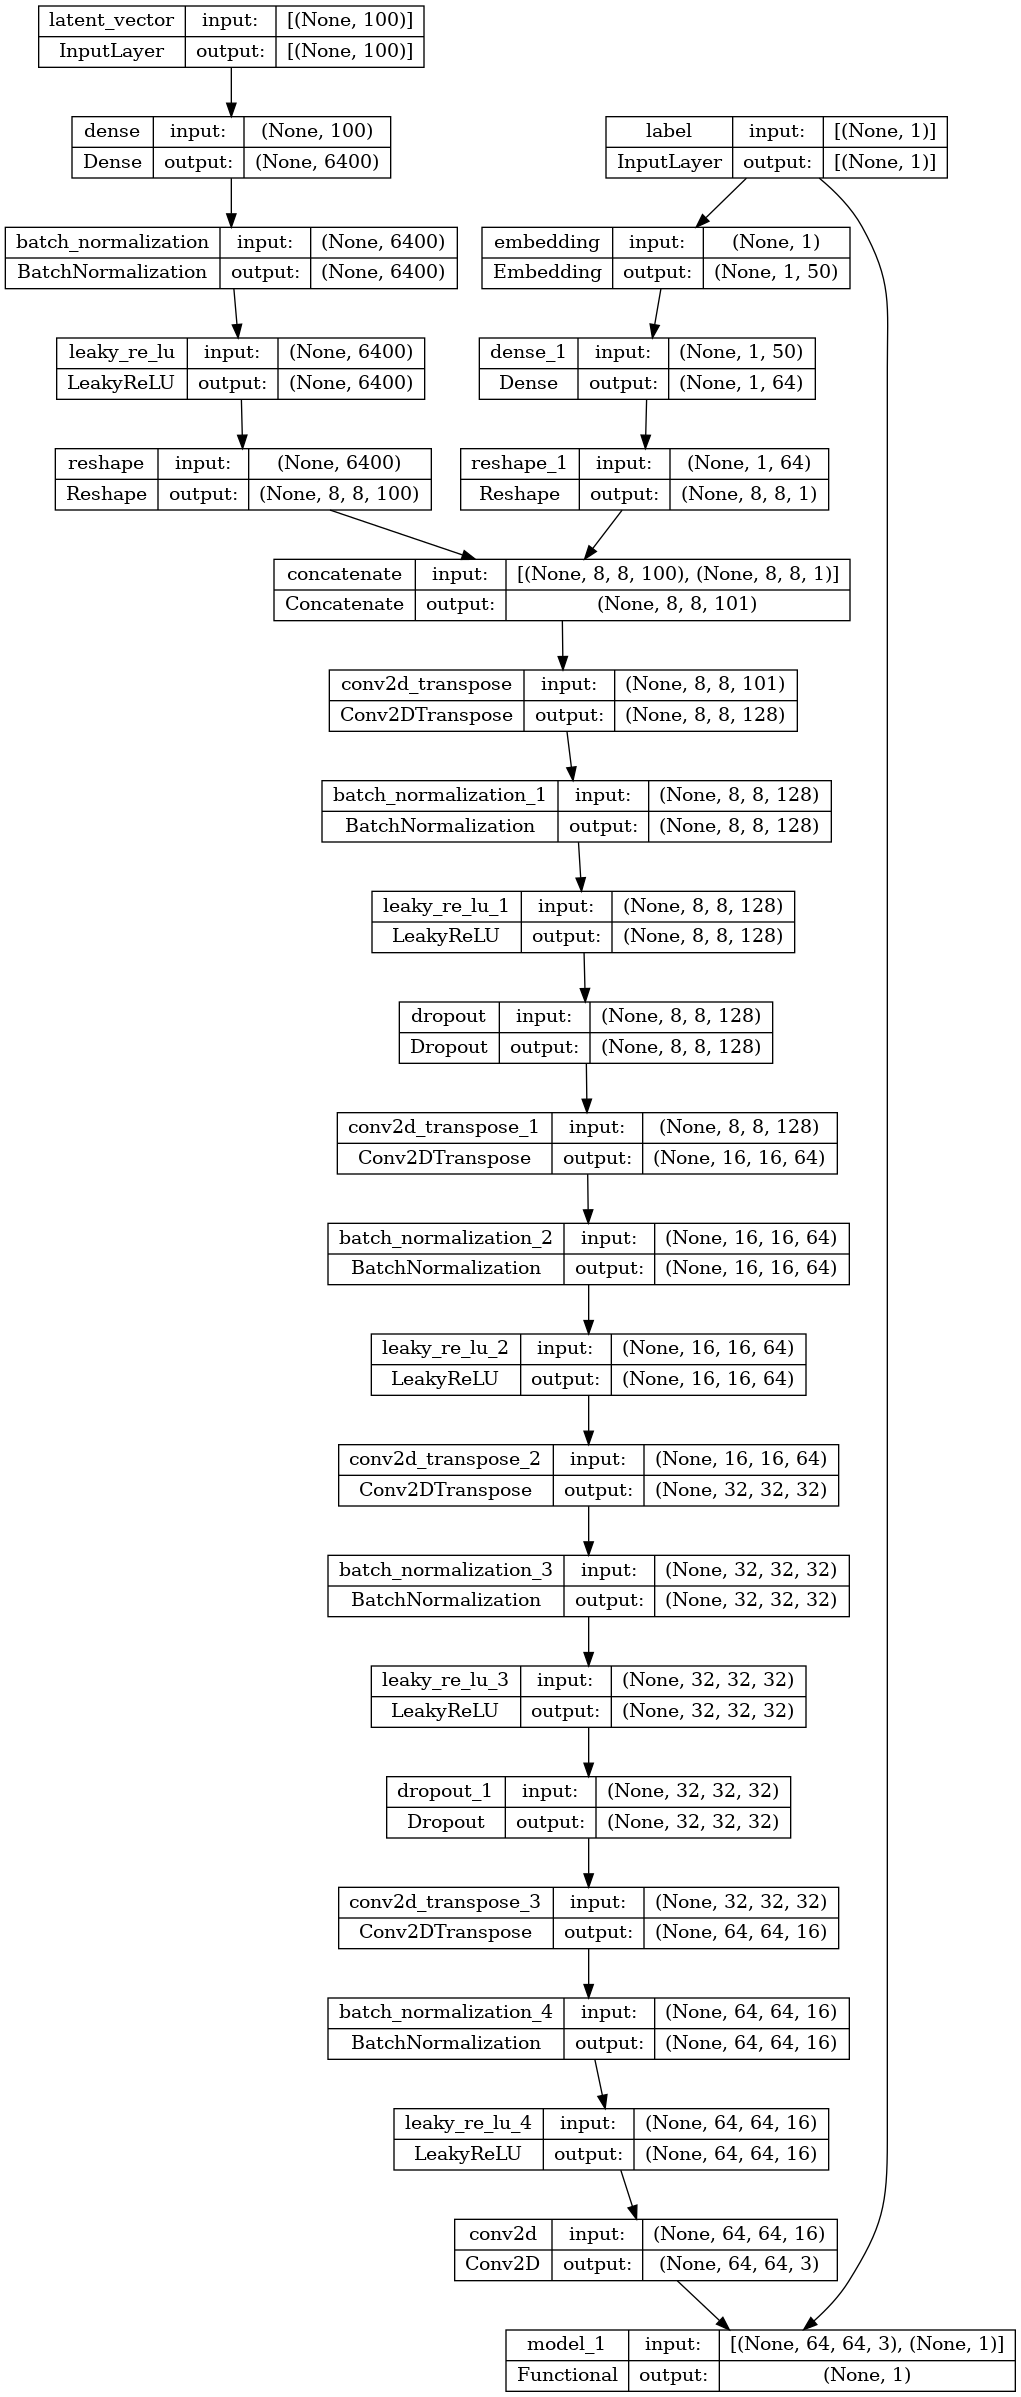

In [10]:
gan = make_gan_model(discriminator, generator)
gan.summary()
tf.keras.utils.plot_model(gan, "cDCGAN/cDCGAN.png", show_shapes=True)

In [11]:
seed = tf.random.normal([16, 100])
label_seed = np.random.randint(0,2, 16)

In [12]:
checkpoint_dir = 'cDCGAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [13]:
noise_layer = layers.GaussianNoise(0.2)

def train_step(images, labels, candidate):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 100])
    fake_labels = np.random.randint(0,2, batch_size)

    generated_images = generator.predict({"latent_vector":noise, "label":fake_labels}, verbose=0)
    
    noisy_generated_images = noise_layer(generated_images, training=False)
    flipped_images = tf.image.random_flip_left_right(images)
    noisy_images = noise_layer(flipped_images, training=False)
    
    
    disc_loss_fake = 0.0
    disc_loss_real = 0.0
    gen_loss = 0.0
    
    if candidate == 0:
        disc_loss_fake, _ = discriminator.train_on_batch([noisy_generated_images, fake_labels], tf.zeros([batch_size,1]))
        disc_loss_real, _ = discriminator.train_on_batch([noisy_images, labels], tf.ones([batch_size,1]))
    elif candidate == 1:
        gen_loss = gan.train_on_batch([noise, fake_labels], tf.ones([batch_size,1]))
    else:
        disc_loss_fake, _ = discriminator.train_on_batch([noisy_generated_images, fake_labels], tf.zeros([batch_size,1]))
        disc_loss_real, _ = discriminator.train_on_batch([noisy_images, labels], tf.ones([batch_size,1]))
        gen_loss = gan.train_on_batch([noise, fake_labels], tf.ones([batch_size,1]))
    
    return gen_loss, disc_loss_real, disc_loss_real

In [18]:
BATCHES = int(214692 / BATCH_SIZE)
def train(dataset, epochs, start_epoch=0, save_checkpoints=True):
    for epoch in range(start_epoch, epochs + start_epoch):
        start = time.time()
        batch = 1
        train_condition = np.random.random([1,1])
        if train_condition > 0 and train_condition < 0.25:
            candidate = 0
        elif train_condition > 0.25 and train_condition < 0.44:
            candidate = 1
        else:
            candidate = 2
        
        for image_batch, labels in dataset:
            gen_loss, disc_loss_real, disc_loss_fake = train_step(image_batch, labels, candidate)
            print(f'{batch}/{BATCHES}: d_real={disc_loss_real} d_fake={disc_loss_fake} gan={gen_loss}', end="\r")
            batch+=1
                
        print(f'd_real={disc_loss_real} d_fake={disc_loss_fake} gan={gen_loss}')
        print("Time for epoch {}: {}".format(epoch, time.time()-start))

        # Produce images for the GIF as you go
        generate_and_save_images(generator,epoch,seed, label_seed)
        
        clear_output(wait=True)
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0 and save_checkpoints:
            manager.save()
            save_latest_epoch(epoch)
            

def generate_and_save_images(model, epoch, test_input, labels):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model([test_input, labels], training=False).numpy()
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]*127.5+127.5).astype("int32"))
        plt.axis('off')

    plt.savefig(os.path.join(checkpoint_dir, "images/",'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

In [15]:
def save_latest_epoch(epoch:int):
    with open(os.path.join(checkpoint_dir, "epoch.txt"), "w") as f:
        f.write(str(epoch))

def get_latest_epoch():
    try:
        with open(os.path.join(checkpoint_dir, "epoch.txt"), "r") as f:
            return int(f.readline())
    except:
        return 0

In [19]:
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    latest_epoch = int(manager.latest_checkpoint.split('-')[1])
    last_epoch = latest_epoch * 15
    print ('Latest checkpoint of epoch {} restored!!'.format(last_epoch))
else:
    last_epoch = 0

Latest checkpoint of epoch 90 restored!!


In [ ]:
LOG_DIR = "cDCGAN/logs/fit"
tb_callback = tf.keras.callbacks.TensorBoard(os.path.join(LOG_DIR, "gen"))
tb_callback.set_model(generator)
tb_disc_callback = tf.keras.callbacks.TensorBoard(os.path.join(LOG_DIR, "disc"))
tb_callback.set_model(discriminator)
%tensorboard --logdir cDCGAN/logs

#tf.profiler.experimental.start('logdir')
train(dataset.prefetch(AUTOTUNE), 5000, last_epoch)
#tf.profiler.experimental.stop()